<h2 style="font-weight: bold">Digit Recognizer</h2>

<h4>This is my third published notebook on Kaggle. Well! Well you guess it! it's gonna be about the Digit Recognizer Competition 😄😄<br><br>I will be doing a simple EDA and Pre-Processing, the I will Build different models<br><br></h4>

* <h5 style="font-weight: 700">Your feedback is very welcome</h5>
* <h5 style="font-weight: 700">If you find this notebook useful, please don't forget to upvote it!</h5>


In [1]:
# Load a few helpful modules
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
from   PIL import Image
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

In [2]:
train = pd.read_csv('../input/digit-recognizer/train.csv')
test = pd.read_csv('../input/digit-recognizer/train.csv')

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#  **Checking the Data**

In [4]:
# check training data
trainLabelCounts = train['label'].value_counts(sort = False)
trainLabelCounts

1    4684
0    4132
4    4072
7    4401
3    4351
5    3795
8    4063
9    4188
2    4177
6    4137
Name: label, dtype: int64

In [5]:
# Construct the transform
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

# Get the device we're training on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_digits(df):
    """Loads images as PyTorch tensors"""
    # Load the labels if they exist 
    # (they wont for the testing data)
    labels = []
    start_inx = 0
    if 'label' in df.columns:
        labels = [v for v in df.label.values]
        start_inx = 1
        
    # Load the digit information
    digits = []
    for i in range(df.pixel0.size):
        digit = df.iloc[i].astype(float).values[start_inx:]
        digit = np.reshape(digit, (28,28))
        digit = transform(digit).type('torch.FloatTensor')
        if len(labels) > 0:
            digits.append([digit, labels[i]])
        else:
            digits.append(digit)

    return digits

In [6]:
# Load the training data
train = get_digits(train)

# Some configuration parameters
num_workers = 0    # number of subprocesses to use for data loading
batch_size  = 64   # how many samples per batch to load
valid_size  = 0.2  # percentage of training set to use as validation

# Obtain training indices that will be used for validation
num_train = len(train)
indices   = list(range(num_train))
np.random.shuffle(indices)
split     = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation batches
from torch.utils.data.sampler import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Construct the data loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size,
                    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, 
                    sampler=valid_sampler, num_workers=num_workers)

# Test the size and shape of the output
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


#  **Modeling & Submitting**

In [7]:
def calc_out(in_layers, stride, padding, kernel_size, pool_stride):
    """
    Helper function for computing the number of outputs from a
    conv layer
    """
    return int((1+(in_layers - kernel_size + (2*padding))/stride)/pool_stride)

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Some helpful values
        inputs      = [1,32,64,64]
        kernel_size = [5,5,3]
        stride      = [1,1,1]
        pool_stride = [2,2,2]

        # Layer lists
        layers = []

        self.out   = 28
        self.depth = inputs[-1]
        for i in range(len(kernel_size)):
            # Get some variables
            padding = int(kernel_size[i]/2)

            # Define the output from this layer
            self.out = calc_out(self.out, stride[i], padding,
                                kernel_size[i], pool_stride[i])

            # convolutional layer 1
            layers.append(nn.Conv2d(inputs[i], inputs[i+1], kernel_size[i], 
                                       stride=stride[i], padding=padding))
            layers.append(nn.ReLU())
            
            # convolutional layer 2
            layers.append(nn.Conv2d(inputs[i+1], inputs[i+1], kernel_size[i], 
                                       stride=stride[i], padding=padding))
            layers.append(nn.ReLU())
            # maxpool layer
            layers.append(nn.MaxPool2d(pool_stride[i],pool_stride[i]))
            layers.append(nn.Dropout(p=0.2))

        self.cnn_layers = nn.Sequential(*layers)
        
        print(self.depth*self.out*self.out)
        
        # Now for our fully connected layers
        layers2 = []
        layers2.append(nn.Dropout(p=0.2))
        layers2.append(nn.Linear(self.depth*self.out*self.out, 512))
        layers2.append(nn.Dropout(p=0.2))
        layers2.append(nn.Linear(512, 256))
        layers2.append(nn.Dropout(p=0.2))
        layers2.append(nn.Linear(256, 256))
        layers2.append(nn.Dropout(p=0.2))
        layers2.append(nn.Linear(256, 10))

        self.fc_layers = nn.Sequential(*layers2)

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(-1, self.depth*self.out*self.out)
        x = self.fc_layers(x)
        return x
    
# create a complete CNN
model = Net()
model

576


Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.2, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.2, inplace=False)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Dropout(p=0.2, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Dropo

In [8]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005)
# number of epochs to train the model
n_epochs = 25 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

model.to(device)
tLoss, vLoss = [], []
for epoch in range(n_epochs):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    #########
    # train #
    #########
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        data   = data.to(device)
        target = target.to(device)
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ############
    # validate #
    ############
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        data   = data.to(device)
        target = target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    tLoss.append(train_loss)
    vLoss.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 0 	Training Loss: 0.222884 	Validation Loss: 0.012895
Validation loss decreased (inf --> 0.012895).  Saving model ...
Epoch: 1 	Training Loss: 0.071040 	Validation Loss: 0.011897
Validation loss decreased (0.012895 --> 0.011897).  Saving model ...
Epoch: 2 	Training Loss: 0.054884 	Validation Loss: 0.009606
Validation loss decreased (0.011897 --> 0.009606).  Saving model ...
Epoch: 3 	Training Loss: 0.048584 	Validation Loss: 0.011303
Epoch: 4 	Training Loss: 0.041937 	Validation Loss: 0.012659
Epoch: 5 	Training Loss: 0.036095 	Validation Loss: 0.009300
Validation loss decreased (0.009606 --> 0.009300).  Saving model ...
Epoch: 6 	Training Loss: 0.038641 	Validation Loss: 0.009793
Epoch: 7 	Training Loss: 0.037662 	Validation Loss: 0.009723
Epoch: 8 	Training Loss: 0.032728 	Validation Loss: 0.010058
Epoch: 9 	Training Loss: 0.033651 	Validation Loss: 0.009089
Validation loss decreased (0.009300 --> 0.009089).  Saving model ...
Epoch: 10 	Training Loss: 0.026056 	Validation Los

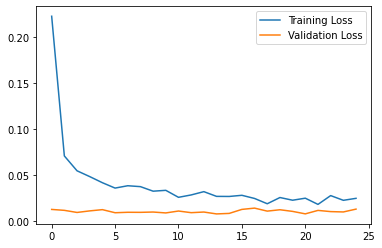

In [9]:
# Plot the resulting loss over time
plt.plot(tLoss, label='Training Loss')
plt.plot(vLoss, label='Validation Loss')
plt.legend();